In [1]:
%matplotlib inline

import os, glob, sys, time, random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils import data

import phate
import scanpy as sc


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats

import tifffile 
from PIL import Image


In [2]:
# filepaths

idfp = '/home/ngr4/project/zfish/data/tifs'
pfp = '/home/ngr4/project/zfish/results/cnn'
pdfp = '/home/ngr4/project/zfish/data/processed'
tfp = '/home/ngr4/project/zfish/data/cifar10/'


# filenames for images
tif_files = glob.glob(os.path.join(idfp,'*.tif'))

# aesthetics
plt.rc('text',usetex=True)

In [3]:
# utils 

def parse_filenames(file_list, n_test=5, verbose=True) : 
    '''Train/test split for 3 timepoint classes'''
    dpf3 = []
    dpf4 = []
    dpf5 = []
    count = 0
    for f in file_list : 
        if '3dpf' in f :
            dpf3.append(f)
        elif '4dpf' in f :
            dpf4.append(f)
        elif '5dpf' in f :
            dpf5.append(f)
        else :
            count+=1
            print('{} files in data folder not matched.\n...Problem file: {}'.format(count,f))
            
    if verbose :
        print('\n3dpf has {}-images'.format(len(dpf3)))
        print('4dpf has {}-images'.format(len(dpf4)))
        print('5dpf has {}-images\n'.format(len(dpf5)))
            
    dpf3_test = random.sample(dpf3,n_test)
    dpf3_train= [i for i in dpf3 if i not in dpf3_test] 
    dpf4_test = random.sample(dpf4,n_test)
    dpf4_train= [i for i in dpf4 if i not in dpf4_test] 
    dpf5_test = random.sample(dpf5,n_test)
    dpf5_train= [i for i in dpf5 if i not in dpf5_test] 
    
    if verbose :
        # for reproducibility, hard code test set op to get train
        print('3 DPF test set...')
        for i in dpf3_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
        print('\n4 DPF test set...')
        for i in dpf4_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
        print('\n5 DPF test set...')
        for i in dpf5_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
            
    return dpf3_train,dpf4_train,dpf5_train,dpf3_test,dpf4_test,dpf5_test

def get_im(fname) : 
    '''returns numpy array on range [0,1]'''
    img = tifffile.imread(fname) 
    if len(img.shape)>2 : #Cxy
        # 2-channel image, 2nd channel has vasculature
        img = img[1,:,:]
    img = img/(2**12 - 1)
    img = img/np.mean(img)
    img = img/20
    img[img>1] = 1
#     img = (img - np.mean(img))/np.std(img) # z-score
#     img = img/np.mean(img)
#     img = img/np.max(img) # scale [0,1]
    return img

def accuracy() :
    '''TODO (unless doing regression)'''
    return None
            
    

In [4]:
# train/test split
d3,d4,d5,d3_test,d4_test,d5_test=parse_filenames(tif_files)
train_files = d3+d4+d5
test_files = d3_test+d4_test+d5_test


3dpf has 49-images
4dpf has 54-images
5dpf has 53-images

3 DPF test set...
    kdrgfp3dpfDec16th2019_Series006_MIP.tif
    Notch3kdrmChpdgfrbeGFP3dpfDec2nd2019_Series002Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP3dpfDec2nd2019_Series008Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP3dpfJan13th2020_Series006Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP3dpfDec2nd2019_Series009Mut_MIP.tif

4 DPF test set...
    Notch3kdrmChpdgfrbeGFP4dpfJan14th2020_Series011Mut_MIP.tif
    kdrgfp4dpfDec17th2019_Series004_MIP.tif
    kdrgfp4dpfDec17th2019_Series005_MIP.tif
    Notch3kdrmChpdgfrbeGFP4dpfDec3rd2019_Series001Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP4dpfJan14th2020_Series008Mut_MIP.tif

5 DPF test set...
    kdrgfp5dpfDec18th2019_Series002_MIP.tif
    kdrgfp5dpfDec18th2019_Series015_MIP.tif
    Notch3kdrmChpdgfrbeGFP5dpfJan15th2020_Series009Mut_MIP.tif
    kdrgfp5dpfNov27th2019_Series009_MIP.tif
    Notch3kdrmChpdgfrbeGFP5dpfDec4th2019_Series001Mut_MIP.tif


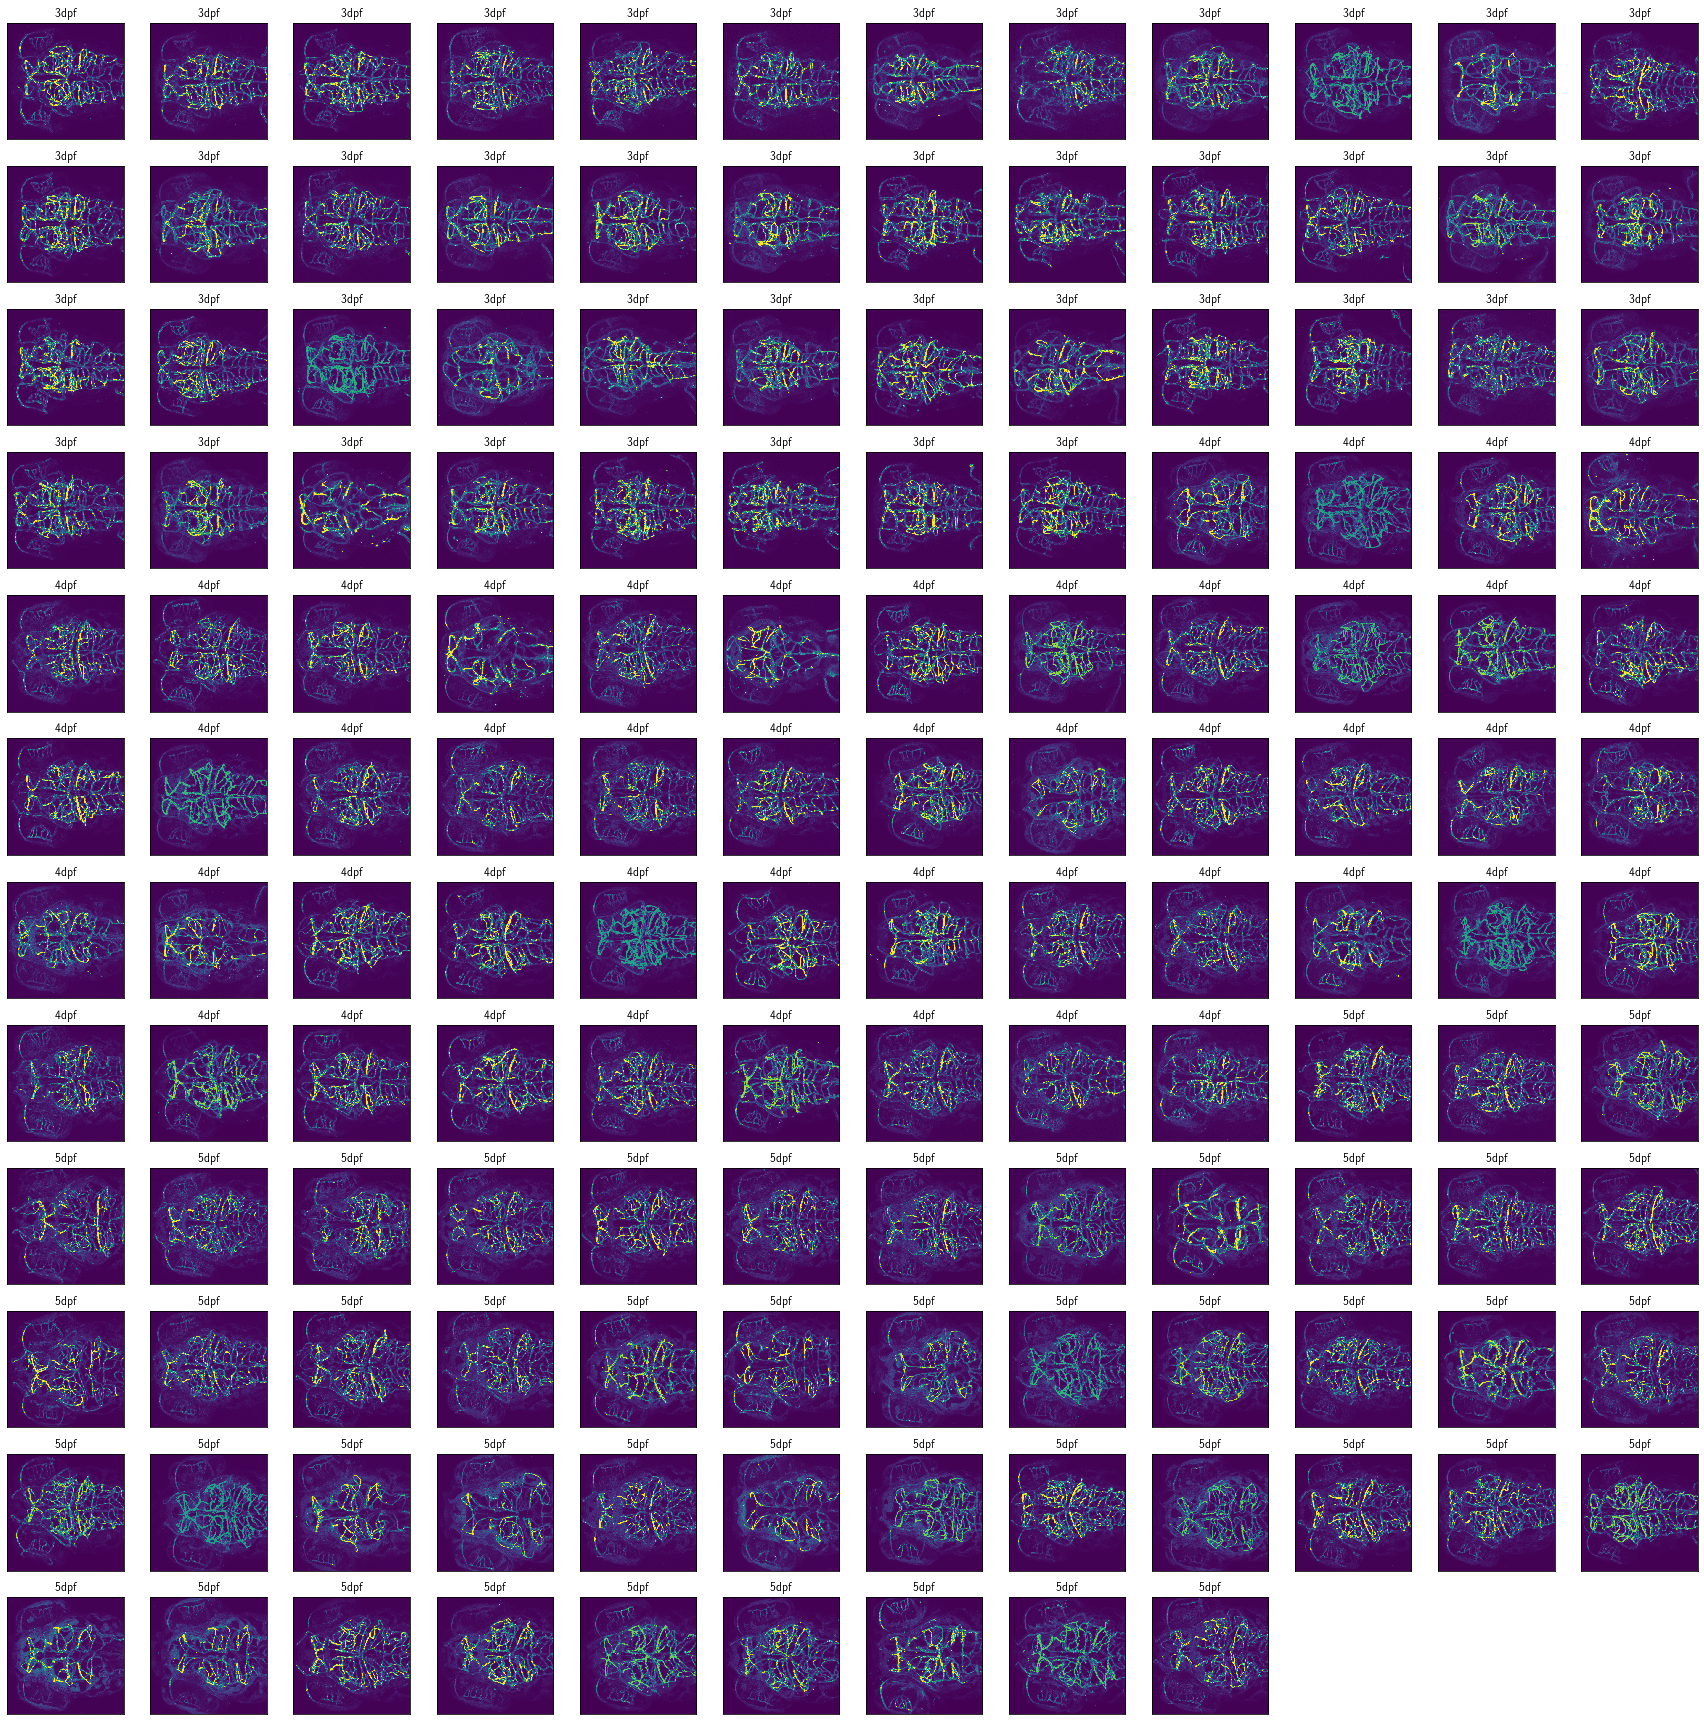

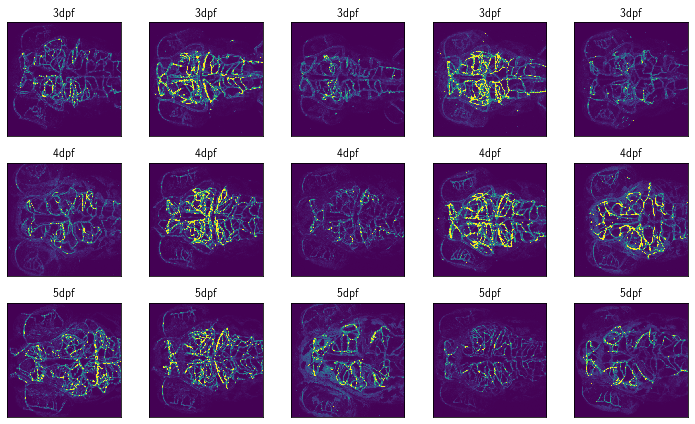

In [5]:
# visualize data

# train
fig = plt.figure(figsize=(24,26))
for i,file in enumerate(train_files) : 
    ax=fig.add_subplot(13,12,i+1)
    img = get_im(file)
    ax.imshow(img, vmin=0, vmax=0.5)
    f = os.path.split(file)[1].split('.tif')[0]
    if '3dpf' in f :
        label = '3dpf'
    elif '4dpf' in f :
        label = '4dpf'
    elif '5dpf' in f :
        label = '5dpf'
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
    
    
# train
fig = plt.figure(figsize=(10,6))
for i,file in enumerate(test_files) : 
    ax=fig.add_subplot(3,5,i+1)
    img = get_im(file)
    ax.imshow(img)
    f = os.path.split(file)[1].split('.tif')[0]
    if '3dpf' in f :
        label = '3dpf'
    elif '4dpf' in f :
        label = '4dpf'
    elif '5dpf' in f :
        label = '5dpf'
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
    

In [6]:
# data loader for sampling 

class zfish(data.Dataset):
    '''List of files to be used for torch generation of image batches'''
    
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.files)

    def __getitem__(self, idx):
        'Generates one sample of data'
        
        # select sample
        file = self.files[idx]
        f = os.path.split(file)[1].split('.tif')[0]

        # load data
        img = get_im(file)
        
        # convert to PIL image
        img = Image.fromarray(img)

        # transform
        if self.transform :
            img = self.transform(img)

        # label (regression task => number given)
        if '3dpf' in f :
            target = -0.5
        elif '4dpf' in f :
            target = 0
        elif '5dpf' in f :
            target = 0.5
        else : 
            print('target mismatch for {}'.format(f))

        return img, target

In [7]:
# load data 

if False :
    # check num_workers available
    import multiprocessing
    pool = multiprocessing.Pool()
    print(pool._processes)

# hyperparams
batch_size_train = 32
batch_size_test = 5
transform = tv.transforms.Compose(
    [tv.transforms.Resize((128,128)), # bilinear interpolation?
     tv.transforms.ToTensor(),
     tv.transforms.Normalize((0.5,),(0.5,))])


# generators
training_set = zfish(train_files, transform=transform)
training_generator = data.DataLoader(training_set, 
                                     batch_size=batch_size_train,
                                     shuffle=True,
                                     num_workers=20)
validation_set = zfish(test_files, transform=transform)
validation_generator = data.DataLoader(validation_set,
                                       batch_size=batch_size_test,
                                       shuffle=True,
                                       num_workers=20)



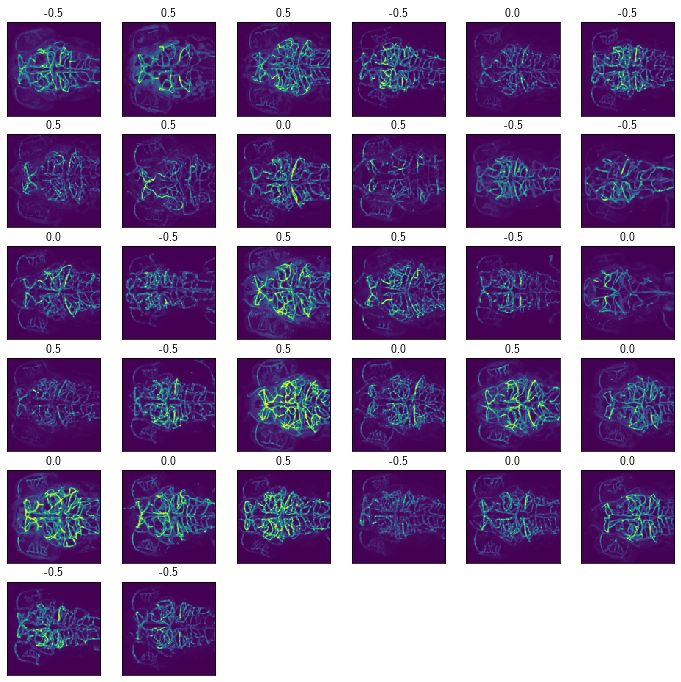

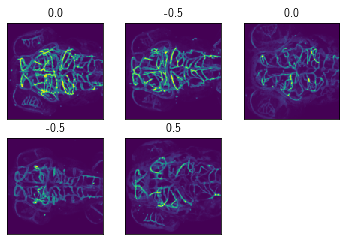

In [8]:
# visualize data

# train
dataiter = iter(training_generator)
images, labels = dataiter.next()

n_=np.ceil(np.sqrt(batch_size_train))

fig = plt.figure(figsize=(int(n_*2),int(n_*2)))
for i in range(images.shape[0]) :
    ax=fig.add_subplot(int(n_),int(n_),i+1)
    ax.imshow(images[i,0,:,:])
    ax.set_title(labels[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
# test
dataiter = iter(validation_generator)
images, labels = dataiter.next()

n_=np.ceil(np.sqrt(batch_size_test))

fig = plt.figure(figsize=(int(n_*2),int(n_*2)))
for i in range(images.shape[0]) :
    ax=fig.add_subplot(int(n_),int(n_),i+1)
    ax.imshow(images[i,0,:,:])
    ax.set_title(labels[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Model momdified from Rashcka, S resources, found [here](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-conv-nneighbor-celeba.ipynb)

In [9]:
# model

class AutoEncoder(nn.Module):
    def __init__(self, in_channels, dec_channels, latent_size):
        super(AutoEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.dec_channels = dec_channels
        self.latent_size = latent_size

        # encder  
        self.e_conv_1 = nn.Conv2d(in_channels, 
                                  dec_channels, 
                                  kernel_size=(4, 4), 
                                  stride=(2, 2), 
                                  padding=1)
        self.e_bn_1 = nn.BatchNorm2d(dec_channels)
        self.e_conv_2 = nn.Conv2d(dec_channels, 
                                  dec_channels*2, 
                                  kernel_size=(4, 4), 
                                  stride=(2, 2), 
                                  padding=1)
        self.e_bn_2 = nn.BatchNorm2d(dec_channels*2)
        self.e_conv_3 = nn.Conv2d(dec_channels*2, 
                                  dec_channels*4, 
                                  kernel_size=(4, 4), 
                                  stride=(2, 2), 
                                  padding=1)
        self.e_bn_3 = nn.BatchNorm2d(dec_channels*4)
        self.e_conv_4 = nn.Conv2d(dec_channels*4, 
                                  dec_channels*8, 
                                  kernel_size=(4, 4), 
                                  stride=(2, 2), 
                                  padding=1)
        self.e_bn_4 = nn.BatchNorm2d(dec_channels*8)
        self.e_conv_5 = nn.Conv2d(dec_channels*8, 
                                  dec_channels*16, 
                                  kernel_size=(4, 4), 
                                  stride=(2, 2), 
                                  padding=1)
        self.e_bn_5 = nn.BatchNorm2d(dec_channels*16)
        self.e_fc_1 = nn.Linear(dec_channels*16*4*4, 
                                latent_size)

        # decoder
        self.d_fc_1 = nn.Linear(latent_size, 
                                dec_channels*16*4*4)
        self.d_conv_1 = nn.Conv2d(dec_channels*16, 
                                  dec_channels*8, 
                                  kernel_size=(4, 4), 
                                  stride=(1, 1), 
                                  padding=0)
        self.d_bn_1 = nn.BatchNorm2d(dec_channels*8)
        self.d_conv_2 = nn.Conv2d(dec_channels*8, 
                                  dec_channels*4, 
                                  kernel_size=(4, 4), 
                                  stride=(1, 1), 
                                  padding=0)
        self.d_bn_2 = nn.BatchNorm2d(dec_channels*4)
        self.d_conv_3 = nn.Conv2d(dec_channels*4, 
                                  dec_channels*2, 
                                  kernel_size=(4, 4), 
                                  stride=(1, 1), 
                                  padding=0)
        self.d_bn_3 = nn.BatchNorm2d(dec_channels*2)
        self.d_conv_4 = nn.Conv2d(dec_channels*2, 
                                  dec_channels, 
                                  kernel_size=(4, 4), 
                                  stride=(1, 1), 
                                  padding=0)
        self.d_bn_4 = nn.BatchNorm2d(dec_channels)
        self.d_conv_5 = nn.Conv2d(dec_channels, 
                                  in_channels, 
                                  kernel_size=(4, 4), 
                                  stride=(1, 1), 
                                  padding=0)
        
        
        # Reinitialize weights using He initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()


    def encode(self, x):
        
        #h1
        x = self.e_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.e_bn_1(x)
        
        #h2
        x = self.e_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)    
        x = self.e_bn_2(x)     

        #h3
        x = self.e_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_3(x)
        
        #h4
        x = self.e_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_4(x)
        
        #h5
        x = self.e_conv_5(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_5(x)        
        
        #fc
        x = x.view(-1, self.dec_channels*16*4*4)
        x = self.e_fc_1(x)
        return x

    def decode(self, x):
        
        # h1
        #x = x.view(-1, self.latent_size, 1, 1)
        x = self.d_fc_1(x)
        
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)  
        x = x.view(-1, self.dec_channels*16, 4, 4) 

        
        # h2
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_1(x)
        
        # h3
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_2(x)
        
        # h4
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_3(x)  

        # h5
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_4(x)
        
        
        # out
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_5(x)
        x = torch.sigmoid(x)
        
        return x

    def forward(self, x):
        z = self.encode(x)
        decoded = self.decode(z)
        return z, decoded

In [10]:
# train

total = time.time()

# initialize model
model = AutoEncoder(in_channels=1,
                    dec_channels=32,
                    latent_size=100)

# hyperparameters
n_epoch = 100
learning_rate = 0.001 # (default) lr=0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # change to AdaGrad

# save losses
train_losses = []
test_losses = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
    train_loss_epoch = []
    test_loss_epoch = []
    
    start = time.time()
    running_loss = 0.0
    for i, d in enumerate(training_generator):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = d

        # zero the parameter gradients
        model.train()
        optimizer.zero_grad()

        # forward + backward + optimize
        latent_vector,decoded = model(inputs)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # evaluate on test set
        test_loss = 0
        model.eval()
        with torch.no_grad() :
            dataiter = iter(validation_generator)
            inputs_val,labels_val = dataiter.next()
            latent_val,decoded_val = model(inputs_val)
            batch_loss = criterion(decoded_val,inputs_val)
            test_loss += batch_loss.item()
        test_loss_epoch.append(test_loss)
        train_loss_epoch.append(running_loss)
        
        print('Epoch {:4d},batch {:3d}\ttrain_loss:{:.6f}\ttest_loss:{:.6f}'.format(epoch+1,i+1,running_loss,test_loss))
        running_loss = 0.0
    
    # average losses, add to overall train/test loss
    ave_train_loss=np.sum(train_loss_epoch)/len(train_loss_epoch)
    ave_test_loss=np.sum(test_loss_epoch)/len(test_loss_epoch)
    train_losses.append(ave_train_loss)
    test_losses.append(ave_test_loss)

    print('...Epoch {} in {:.2f}-s\t<train_loss>:{:.6f}\t<test_loss>:{:.6f}\n'.format(epoch+1,time.time() - start,ave_train_loss,ave_test_loss))
    
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch, i + 1, running_loss / 2000))
#             running_loss = 0.0

print("\nTraining finished in {:.2f}-min".format((time.time() - total)/60))

Epoch    1,batch   1	train_loss:2.039003	test_loss:3.604246
Epoch    1,batch   2	train_loss:1.941783	test_loss:3.564198
Epoch    1,batch   3	train_loss:1.743800	test_loss:2.838162
Epoch    1,batch   4	train_loss:1.631291	test_loss:2.491397
Epoch    1,batch   5	train_loss:1.554028	test_loss:1.888353
...Epoch 1 in 25.77-s	<train_loss>:1.781981	<test_loss>:2.877271

Epoch    2,batch   1	train_loss:1.466260	test_loss:1.762448
Epoch    2,batch   2	train_loss:1.429308	test_loss:1.593462
Epoch    2,batch   3	train_loss:1.420617	test_loss:1.461179
Epoch    2,batch   4	train_loss:1.351029	test_loss:1.409403
Epoch    2,batch   5	train_loss:1.340183	test_loss:1.328178
...Epoch 2 in 25.59-s	<train_loss>:1.401479	<test_loss>:1.510934

Epoch    3,batch   1	train_loss:1.294302	test_loss:1.305173
Epoch    3,batch   2	train_loss:1.270506	test_loss:1.246132
Epoch    3,batch   3	train_loss:1.239666	test_loss:1.270285
Epoch    3,batch   4	train_loss:1.234060	test_loss:1.242903
Epoch    3,batch   5	train_l

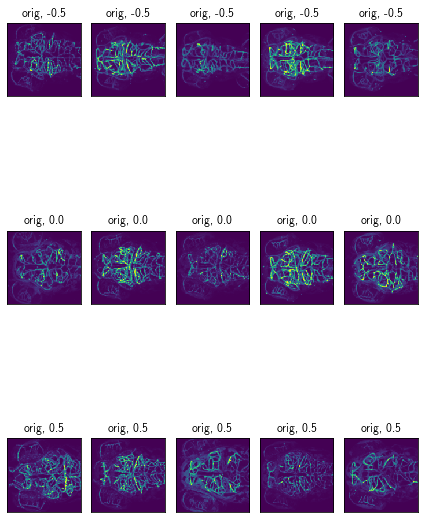

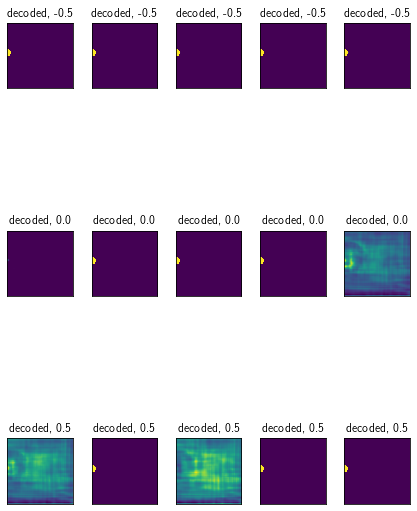

In [11]:
# visualize decoded
get_test = data.DataLoader(validation_set, 
                           batch_size=len(validation_set),
                           shuffle=False,
                           num_workers=20)
dataiter = iter(get_test)
images, labels = dataiter.next()
model.eval()
latent,decoded = model(images)
latent = latent.detach()
decoded = decoded.detach()

# convert to numpy 
decoded = decoded.numpy()
images = images.numpy()

# original
fig = plt.figure(figsize=(6,10))
for i in range(images.shape[0]) :
    ax=fig.add_subplot(3,5,i+1)
    ax.imshow(images[i,0,:,:])
    ax.set_title('orig, {}'.format(labels[i].numpy()))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()

# decoded
fig = plt.figure(figsize=(6,10))
for i in range(decoded.shape[0]) :
    ax=fig.add_subplot(3,5,i+1)
    ax.imshow(decoded[i,0,:,:])
    ax.set_title('decoded, {}'.format(labels[i].numpy()))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()

Text(0.5, 0, 'Epoch')

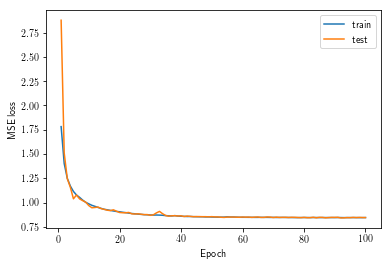

In [12]:
# plot losess (ave across batches)
loss = pd.DataFrame({'train':train_losses,
                     'test':test_losses,
                     'epoch':range(1,len(train_losses)+1)})
loss = pd.melt(loss,value_vars=['train','test'],id_vars=['epoch'])
ax = sns.lineplot(x='epoch',y='value',hue='variable',data=loss)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_ylabel('MSE loss')
ax.set_xlabel('Epoch')